In [2]:
# general imports
import torch
import torch.nn as nn

# neuralop imports
from neuralop.layers.gno_block import GNOBlock
from neuralop.layers.channel_mlp import ChannelMLP
from neuralop.layers.fno_block import FNOBlocks

# data set imports
import dataset_utils as du
from torch.utils.data import DataLoader, random_split

Import Data

In [4]:
B = 1 # must use batch size of 1 for GNOBlock

# load dataset
dataset = du.SDFDataset("./cars100")
train_percent = 0.95 

# split dataset into training and validation sets
train_size = int(train_percent * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# create data loaders for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=B, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=B, shuffle=False, num_workers=4, pin_memory=True)

print(f"Train dataset size: {len(train_dataset)}, Validation dataset size: {len(val_dataset)}")

Train dataset size: 95, Validation dataset size: 5


Define Useful Functions for Data

In [5]:
def process_batch(batch, grid_size, query_size, input_size):
    # y
    input_geom = batch[:, :input_size, :3]  # x, y, z coordinates
    input_geom = input_geom.squeeze(0) 

    # x (grid points in 3D space) generate 64x64x64 grid with bounds [-1, 1] in each dimension
    coords = torch.linspace(-1.0, 1.0, grid_size) 
    x, y, z = torch.meshgrid(coords, coords, coords, indexing='ij') 
    latent_queries = torch.stack((x, y, z), dim=-1)
    # transform to match batch size
    latent_queries = latent_queries.repeat(B, 1, 1, 1, 1)  # Repeat for batch size B
    latent_queries = latent_queries.squeeze(0) 

    # f_y
    features = batch[:, :input_size, 3]  # features (e.g., colors, normals)
    features = features.unsqueeze(-1).squeeze(0)  

    # queries (for now just the same as input_geom)
    output_queries = input_geom.clone().squeeze()[:query_size,:]  # !For now, just use first 1000 points of input_geom as output_queries
    output_labels = features.clone()[:query_size,:]  # !For now, just use first 1000 points of features as output_labels
    return input_geom, latent_queries, features, output_queries, output_labels

# test
batch = next(iter(train_loader))
input_geom, latent_queries, features, output_queries, output_labels = process_batch(batch, grid_size=64, query_size=1000, input_size=1000)

    

Define Model

In [9]:
class SDFGNO(nn.Module):
    def __init__(self,
                 in_channels=1,
                 coord_dim=3,
                 out_channels=10,
                 lifting_channels=16,
                 fno_hidden=32,
                 proj_channels=16,
                 fno_layers=4,
                 fno_modes=(16,16,16),
                 grid_size=8,
                 query_size=50000,
                 input_size=10000):
        super().__init__()
        radius = 0.1 / grid_size
        
        # encoder GNO
        self.gno_in = GNOBlock(in_channels=in_channels,
                               out_channels=out_channels,
                               coord_dim=coord_dim,
                               radius=radius)

        # lift into FNO space
        self.lifting = ChannelMLP(in_channels=out_channels,
                                  hidden_channels=lifting_channels,
                                  out_channels=fno_hidden,
                                  n_layers=2)

        # a stack of Fourier layers
        self.fno_blocks = FNOBlocks(in_channels=fno_hidden,
                                    out_channels=fno_hidden,
                                    n_modes=fno_modes,
                                    n_layers=fno_layers)

        # decoder GNO
        self.gno_out = GNOBlock(in_channels=fno_hidden,
                                out_channels=1,
                                coord_dim=coord_dim,
                                radius=radius)

        # final projection to SDF scalar
        self.projection = ChannelMLP(in_channels=fno_hidden,
                                     hidden_channels=proj_channels,
                                     out_channels=1,
                                     n_layers=2)

        # store grid_size for forward
        self.grid_size = grid_size
        self.query_size = query_size
        self.input_size = input_size
        
        
    def forward(self, batch):
        """
        batch: Tensor of shape [1, N, 4]  (x,y,z, sdf_true)
        returns: Tensor of shape [Q, 4]  query (x,y,z,sdf)
        """
        B, N, _ = batch.shape
        assert B == 1, "GNOBlock requires batch size = 1"
        
        # process batch to get input_geom, latent_queries, features, output_queries
        input_geom, latent_queries, features, output_queries, output_labels = process_batch(batch, self.grid_size, self.query_size, self.input_size)
        
        """ GNOBlock Encoding """
        reshaped_queries = latent_queries.view((-1, latent_queries.shape[-1]))  # Reshape for GNOBlock input
        in_p = self.gno_in(y=input_geom, x=reshaped_queries, f_y=features)
        # reshape
        grid_shape = latent_queries.shape[:-1] # disregard positional encoding dim
        in_p = in_p.view((B, *grid_shape, -1)) # add batch

        """ Lifting to FNO latent space """ # Input shape after lifting: torch.Size([1, FNO_HIDDEN_CHANNELS, 10, 10, 10])
        # reshape
        in_p = in_p.permute(0, len(in_p.shape)-1, *list(range(1,len(in_p.shape)-1)))
        in_p = self.lifting(in_p)

        """ Latent Embedding with FNO Blocks """ # Input shape after FNOBlocks: torch.Size([1, 10, 10, 10,  FNO_HIDDEN_CHANNELS])
        for idx in range(self.fno_blocks.n_layers):
            in_p = self.fno_blocks(in_p, idx)
        latent_embed = in_p.permute(0, 2, 3, 4, 1)  # Reshape to [B, grid_size, grid_size, grid_size, FNO_HIDDEN_CHANNELS]
        
        """ GNOBlock Decoding """ 
        reshaped_embed = latent_embed.view((-1, latent_embed.shape[-1]))  # Reshape for GNOBlock input
        out = self.gno_out(y=reshaped_queries, x=output_queries, f_y=reshaped_embed)

        """ Projection """
        out = out.unsqueeze(0).permute(0, 2, 1)  # Reshape to [B, num_queries, FNO_HIDDEN_CHANNELS] for projection
        out = self.projection(out)
       
        # convert to SDF values
        out = out.squeeze(0).permute(1, 0)  # Reshape to [num_queries, B] for SDF output
        out = torch.cat((output_queries, out), dim=1)  # Concatenate along the feature dimension
        
        return out, output_labels


Define Loss

In [10]:
loss_fn = nn.MSELoss()  # Mean Squared Error loss for SDF regression

def compute_loss(predictions, labels):
    # Extract the SDF values from predictions and targets
    pred_sdf = predictions[:, 3]  # Assuming the SDF is in the last column
    
    return loss_fn(pred_sdf, labels)  # Compute MSE loss

Training

In [13]:
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SDFGNO().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 5
for epoch in tqdm(range(num_epochs), desc="Training Epochs"):
    model.train()
    running_loss = 0.0
    for batch in tqdm(train_loader, desc="Training Batches"):
        batch = batch.to(device)  # Move batch to device
        optimizer.zero_grad()  # Zero the gradients
        
        # Forward pass
        predictions, labels = model(batch)
        
        # Compute loss
        loss = compute_loss(predictions, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")


Training Epochs:  20%|██        | 1/5 [00:29<01:58, 29.74s/it]

Epoch 1/5, Loss: 0.0379


Training Epochs:  40%|████      | 2/5 [00:52<01:16, 25.61s/it]

Epoch 2/5, Loss: 0.0260


Training Epochs:  60%|██████    | 3/5 [01:15<00:48, 24.32s/it]

Epoch 3/5, Loss: 0.0260


Training Epochs:  80%|████████  | 4/5 [01:37<00:23, 23.62s/it]

Epoch 4/5, Loss: 0.0260


Training Epochs: 100%|██████████| 5/5 [02:00<00:00, 24.02s/it]

Epoch 5/5, Loss: 0.0260


Save Model

In [14]:
# save model
torch.save(model.state_dict(), "sdf_gno_model.pth")

Evaluate Model

TRUE


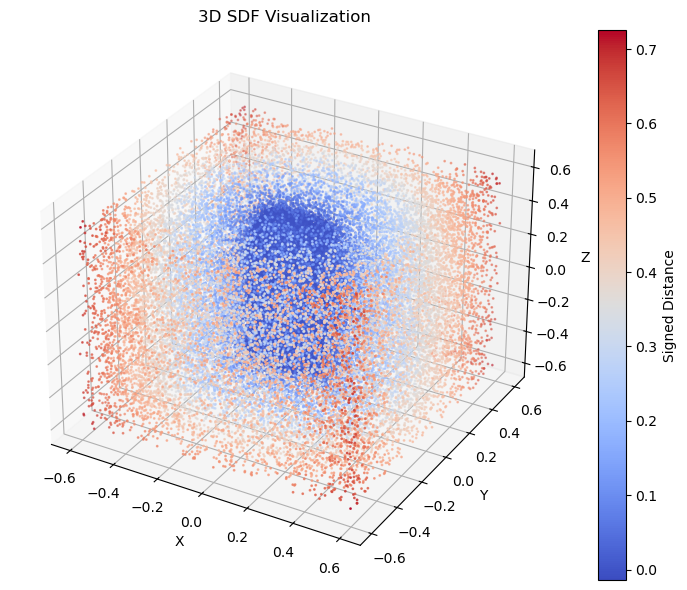

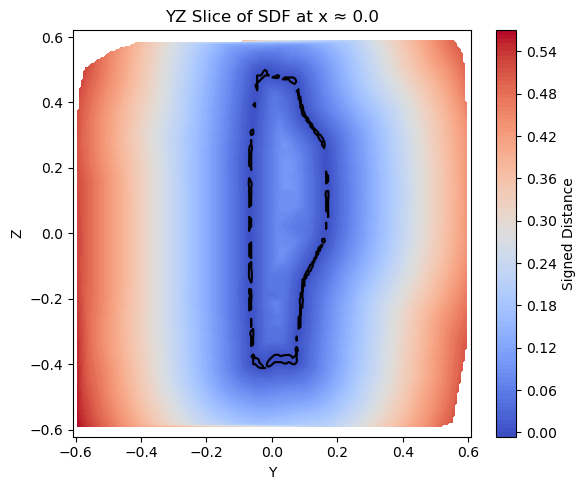

MODEL


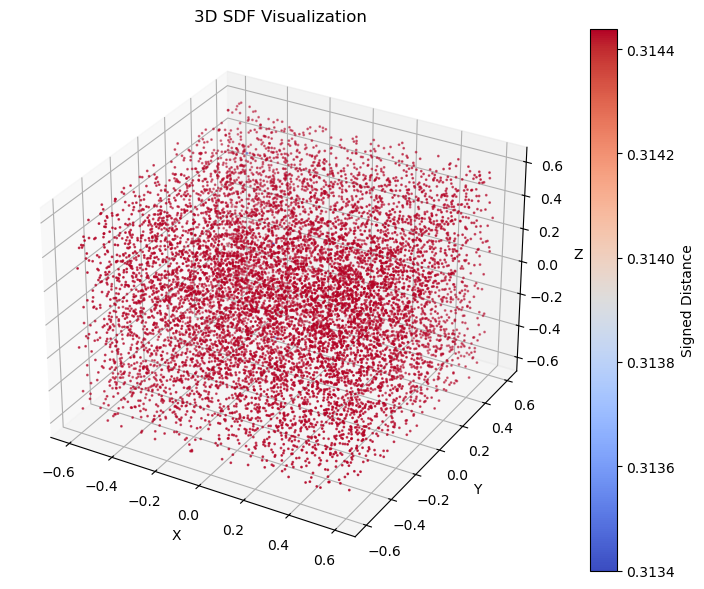

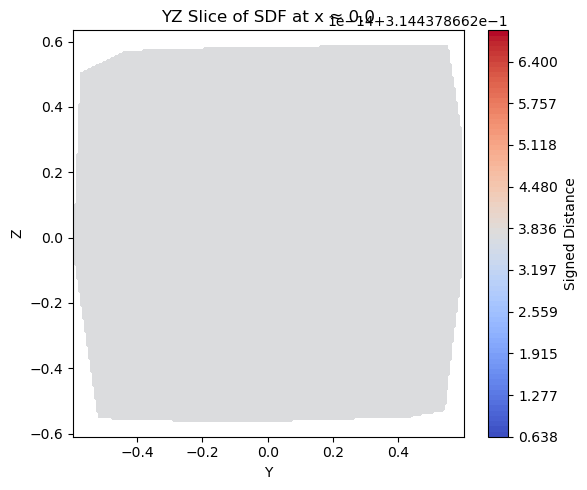

In [15]:
model.eval()
test_batch = next(iter(val_loader))
test_batch = test_batch.to(device)  # Move batch to device
predictions, labels = model(test_batch)

print("TRUE")
du.visualize_sdf_3d(test_batch.squeeze(0))
du.visualize_sdf_2d(test_batch.squeeze(0))
print("MODEL")
du.visualize_sdf_3d(predictions.detach())
du.visualize_sdf_2d(predictions.detach())

